Analyze EMG vs head motion vs DLC motion data for each animal / session.

In [150]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/Projects_sandbox'])
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/Projects_sandbox'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.core.session import ProcessData
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.io.sleepscoremasterio import SleepScoreIO
from neuropy.io.dlcio import DLC
from neuropy.utils.mathutil import min_max_scaler, min_max_external_scaler, quantile_scaler

from Psilocybin.subjects import get_psi_dir

# These are crucial parameters - otherwise all text gets output with each letter in a word or heading as a separate unit
# instead of a text box
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Specify Arial as font type - also crucial
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Specify desired place to plot here.
plot_dir = Path("/Users/nkinsky/University of Michigan Dropbox/Nathaniel Kinsky/Manuscripts/Psilocybin/plots")

## Specify plotting parameters

In [5]:
animals = ["Finn", "Rey", "Rose", "Finn2"]
rasterize_scatter = True # This is crucial, default (False) will produce unweildy plots

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load in animal data

In [54]:
animal = "Finn2"
session = "Saline2"

# Load in session
sess = ProcessData(get_psi_dir(animal, session))

# Load in Miniscope data and process head angular position
sess.miniscope = MiniscopeIO(sess.basepath)
sess.miniscope.load_all_orientation()
sess.miniscope.load_aligned_timestamps()
sess.headpos = sess.miniscope.to_head_ang_pos(times="aligned")

# Load in DeepLabCut position data
sess.dlc = DLC(sess.basepath)
sess.dlc.get_timestamps()
sess.dlc.load_opti_aligned_timestamps()
sess.dlc.smooth_pos()
sess.dlc.get_all_speed()

# Load in EMG data from sleepscoremaster
sess.sio = SleepScoreIO(sess.basepath)
sess.emg = sess.sio.read_emg()

# Load in injection data
sess.injection = Epoch(epochs=None, file=sorted(sess.basepath.glob("*.injection.npy"))[0])


including folder /data3/Psilocybin/Recording_Rats/Finn2/2023_05_26_saline2/pre/Finn2/gobears/2023_05_26/11_44_01
including folder /data3/Psilocybin/Recording_Rats/Finn2/2023_05_26_saline2/pre/Finn2/gobears/2023_05_26/11_46_17
including folder /data3/Psilocybin/Recording_Rats/Finn2/2023_05_26_saline2/saline2/Finn2/gobears/2023_05_26/12_05_11
including folder /data3/Psilocybin/Recording_Rats/Finn2/2023_05_26_saline2/saline2/Finn2/gobears/2023_05_26/12_31_22
including folder /data3/Psilocybin/Recording_Rats/Finn2/2023_05_26_saline2/saline2/Finn2/gobears/2023_05_26/12_48_55
including folder /data3/Psilocybin/Recording_Rats/Finn2/2023_05_26_saline2/saline2/Finn2/gobears/2023_05_26/13_01_47
including folder /data3/Psilocybin/Recording_Rats/Finn2/2023_05_26_saline2/saline2/Finn2/gobears/2023_05_26/13_20_03
including folder /data3/Psilocybin/Recording_Rats/Finn2/2023_05_26_saline2/saline2/Finn2/gobears/2023_05_26/13_20_57
including folder /data3/Psilocybin/Recording_Rats/Finn2/2023_05_26_salin

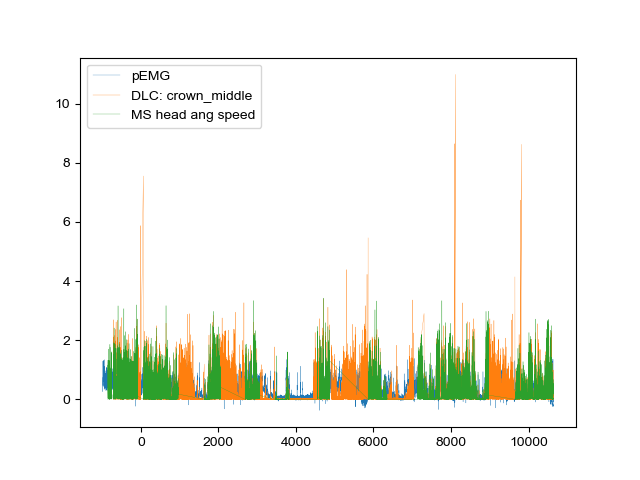

In [155]:
fig, ax = plt.subplots()
ax.plot(sess.emg.timestamps - inj_time, quantile_scaler(sess.emg.pEMG.values), linewidth=0.2, label="pEMG")
ax.plot(sess.dlc.times_aligned.eeg_aligned_times - inj_time, 
        quantile_scaler(sess.dlc.speed[bodypart].values), label=f"DLC: {bodypart}", linewidth=0.2)
ax.plot(sess.headpos.time - inj_time, quantile_scaler(sess.headpos.speed), label="MS head ang speed", linewidth=0.2)
ax.legend()

In [151]:
quantile_scaler(sess.emg.pEMG.values)

array([ 0.74106063,  0.61228651,  0.63418176, ..., -0.08250005,
        0.06094907,  1.35236503])

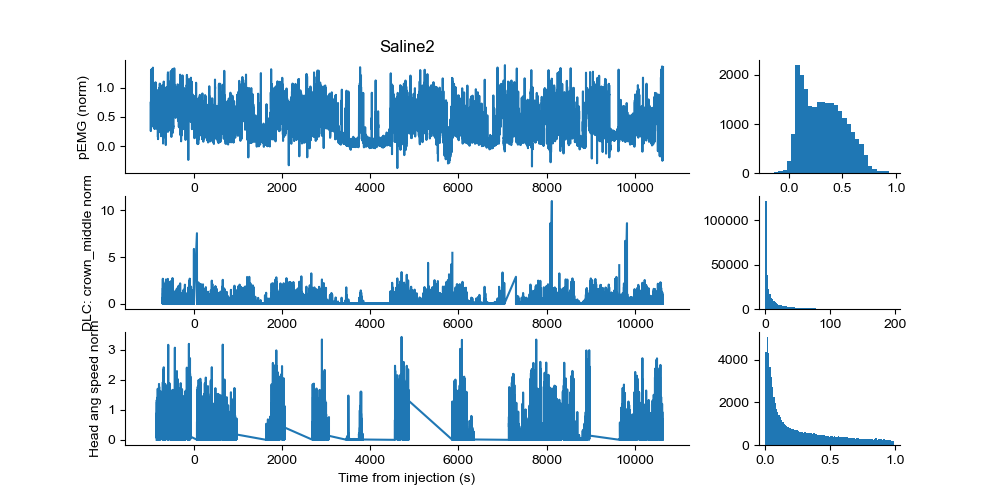

In [153]:
%matplotlib widget

inj_time = sess.injection["POST"].starts[0]
bodypart = "crown_middle"  # "back_middle" or "crown_middle" are best

# Time-series plots
fig, axs = plt.subplots(3, 2, width_ratios=[4, 1], figsize=(10, 5))
ax = axs[:, 0]
ax[0].plot(sess.emg.timestamps - inj_time, min_max_scaler(sess.emg.pEMG.values), label="pEMG")
ax[0].set_ylabel("pEMG (norm)")
ax[1].plot(sess.dlc.times_aligned.eeg_aligned_times - inj_time, 
        min_max_scaler(sess.dlc.speed[bodypart].values), label=f"DLC: {bodypart}")
ax[1].set_ylabel(f"DLC: {bodypart} norm")
ax[2].plot(sess.headpos.time - inj_time, min_max_scaler(sess.headpos.speed), label="MS head ang speed")
ax[2].set_ylabel("Head ang speed norm")
ax[2].sharex(ax[0])
ax[1].sharex(ax[0])

ax[2].set_xlabel("Time from injection (s)")
ax[0].set_title(session)

# Histograms
axh = axs[:, 1]
axh[0].hist(sess.emg.pEMG.values, 30)
axh[1].hist(sess.dlc.speed[bodypart], bins=np.arange(0, 200, 2))
axh[2].hist(sess.headpos.speed, bins=np.arange(0, 1, 1/100))
# ax.legend()
sns.despine(fig=fig)


In [165]:
sess.mini

-1          137.049200
 0          137.143200
 1          137.185200
 2          137.251200
 3          137.319200
              ...     
 12086    11624.640933
 12087    11624.707933
 12088    11624.775933
 12089    11624.842933
 12090    11624.909933
Name: Timestamps, Length: 92697, dtype: float64

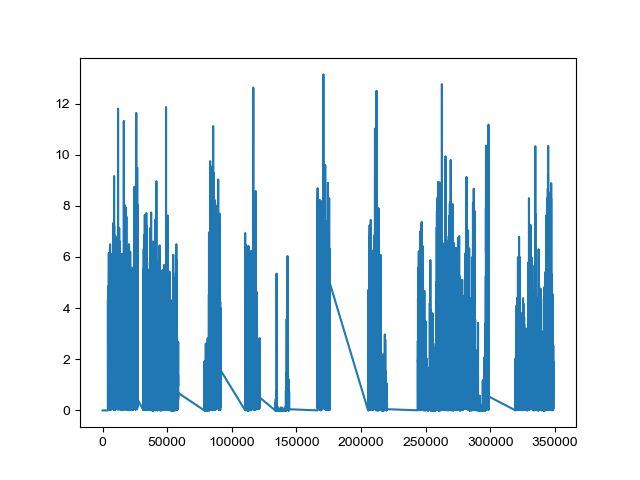

In [164]:
_, ax = plt.subplots()
ax.plot(np.interp(tref, sess.headpos.time, sess.headpos.speed))

In [187]:
sess.emg.pEMG.values

array([ 0.54089259,  0.45351614,  0.46837261, ..., -0.01791385,
        0.07941995,  0.95567785])

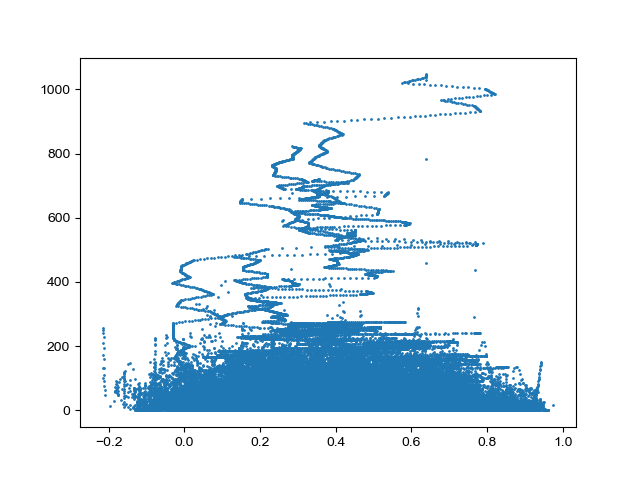

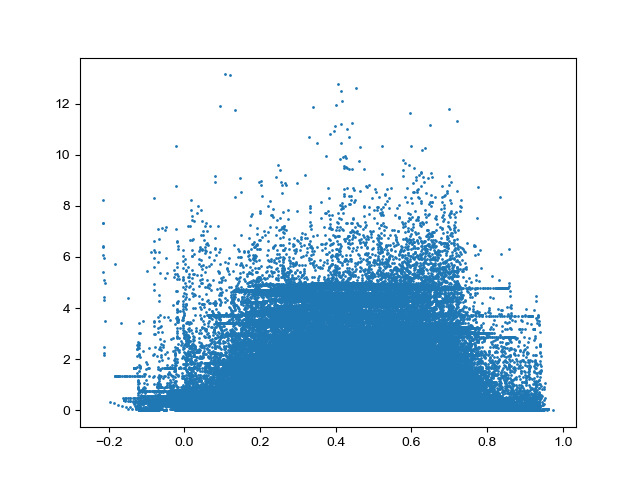

In [190]:
SR = 30
tref = np.arange(0, sess.emg.timestamps.max(), 1/SR)

emg_interp = np.interp(tref, sess.emg.timestamps.values, sess.emg.pEMG.values)

for tuse, met_use, met_name in zip([sess.dlc.times_aligned.eeg_aligned_times, sess.headpos.time],
                                   [sess.dlc.speed[bodypart].values, sess.headpos.speed],
                                   [f"DLC {bodypart} speed", "Head Ang speed"]):
    met_interp = np.interp(tref, tuse, met_use)

    _, ax = plt.subplots()
    ax.scatter(emg_interp, met_interp, s=1)

In [176]:
sess.miniscope.load_all_timestamps()
sess.miniscope.times_all

[autoreload of neuropy.io.miniscopeio failed: Traceback (most recent call last):
  File "/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/data/GitHub/NeuroPy/neuropy/io/miniscopeio.

Frame Number  Time Stamp (ms)  Buffer Index  \
0                 0              -63             0   
1                 1               31             0   
2                 2               73             0   
3                 3              139             0   
4                 4              207             0   
...             ...              ...           ...   
12087         12087           814336             0   
12088         12088           814403             0   
12089         12089           814471             0   
12090         12090           814538             0   
12091         12091           814605             0   

                            Timestamps  Recording  
0     2023-05-26 11:44:01.782000-04:00          0  
1     2023-05-26 11:44:01.876000-04:00          0  
2     2023-05-26 11:44:01.918000-04:00          0  
3     2023-05-26 11:44:01.984000-04:00          0  
4     2023-05-26 11:44:02.052000-04:00          0  
...                                ...        ...  
12087 2023-05-26 15:08:35.908000-04:00         14  
12088 2023-05-26 15:08:35.975000-04:00         14  
12089 2023-05-26 15:08:36.043000-04:00         14  
12090 2023-05-26 15:08:36.110000-04:00         14  
12091 2023-05-26 15:08:36.177000-04:00         14  

[92697 rows x 5 columns]

In [181]:
ms_rec_epochs = sess.miniscope.rec_times_from_timestamps()
ms_rec_epochs.contains(tref)

(array([False, False, False, ..., False, False, False]),
 array([  137.06666667,   137.1       ,   137.13333333, ...,
        11624.83333333, 11624.86666667, 11624.9       ]),
 array(['0', '0', '0', ..., '14', '14', '14'], dtype=object))

In [171]:
rec_times = []
for nrec in sess.miniscope.times_aligned.Recording.unique():
    rec_use = sess.miniscope.times_aligned[sess.miniscope.times_aligned.Recording == nrec]
    rec_times.append(rec_use.Timestamps.values[[0, -1]].squeeze())
np.array(rec_times)

array([[  137.0492    ,   233.3322    ],
       [  272.8195    ,   905.9045    ],
       [ 1051.42173333,  1951.32373333],
       [ 2622.5466    ,  3043.0536    ],
       [ 3676.02693333,  4047.95493333],
       [ 4447.48556667,  4811.79956667],
       [ 5543.48346667,  5552.71446667],
       [ 5597.41596667,  5856.35096667],
       [ 6847.74906667,  7337.25306667],
       [ 8128.94976667,  8219.23476667],
       [ 8227.07316667,  8710.10816667],
       [ 8741.06666667,  9075.80166667],
       [ 9105.1722    ,  9955.7562    ],
       [10643.52396667, 10771.27296667],
       [10810.23793333, 11624.90993333]])

In [ ]:
# Interpolate each data point to smallest timescale (DLC?) and then plot scatterplots versus each other

# Plot histograms of each as well! Maybe next to the plots above?